РОБОТИ ПІСЛЯ ДЕДЛАЙНУ НЕ ПРИЙМАТИМУТЬСЯ.

Ви маєте продемонструвати всі теоретичні та практичні навички здобуті під час курсу. Також можливе використання вже існуючих моделей і алгоритмів при умові, що автор може пояснити і обґрунтувати свій вибір.



Завдання

Вам необхідно створити .ipynb або .py файл для роботи з датасетом, що описаний нижче. Ваш файл має включати наступні стандартні кроки розробки алгоритмів нейронних мереж:

Аналіз та препроцесинг датасету (пояснення + аргументація застосування тих чи інших функцій).
Розробка моделі (пояснення + аргументація вибору/побудови архітектури, тюнінг гіперпараметрів моделі, досягнення максимальної точності, робота з тренувальним протоколом).
Тестування моделі, оформлення підсумків та результатів.
До результатів на distedu разом з кодом також необхідно долучити state dict вашої натренованої моделі (приклад зберігання був на практиці). Модель буде перевірена на валідаційному датасеті одразу після завершення дедлайну. Саме це і є причиною того, що роботи після дедлайну не прийматимуться.



Датасет "У світі дикої природи"

Файли датасету можна знайти в файлах команди тімз та за посиланням.

Він містить близько 28 тисяч зображень тварин середньої якості, що належать до 10 категорій: собака, кішка, кінь, павук, метелик, курка, вівця, корова, білка та слон.

Датасет можна використовувати  для тестування різних мереж розпізнавання зображень. Це могло б імітувати розумну галерею для дослідника (наприклад, біолога).

Усі зображення було зібрано з "google images" і перевірено людьми. Є деякі помилкові дані для імітації реальних умов (наприклад, зображення, зроблені користувачами вашої програми з телефону).

Основний каталог розділений на папки, по одній для кожної категорії. Кількість зображень для кожної категорії коливається від 2K до 5K одиниць.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import time
from tqdm import tqdm
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


У попередніх двох писала англійською, тут вже писатиму українською. Отож, спочатку даємо доступ колабу до данних. І на всяк випадок робимо їх копію перед перетворенням, щоб якщо-що знову не перезаливати.

In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/animals.zip'  # Replace with the path to your zip file
extract_path = 'data/'  # Replace with the desired extraction path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!cp -r data/animals data_second/

спочатку треба подивитися на кількість даних на кожен клас, який ми маємо.

['chicken', 'sheep', 'cat', 'cow', 'dog', 'horse', 'squirrel', 'spider', 'elephant', 'butterfly']


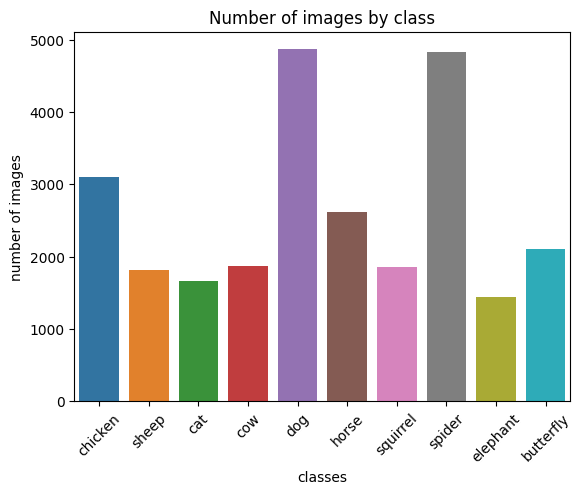

In [4]:
path = 'data/animals'

objects_all = os.listdir(path)
objects = [x for x in objects_all if x != '.DS_Store']
print(objects)
images = []

for item in objects:
  number_of_images = len(os.listdir(path + '/' + item))
  images.append(number_of_images)

sns.barplot(x=objects, y=images)
plt.xlabel('classes')
plt.ylabel('number of images')
plt.title('Number of images by class')
plt.xticks(rotation=45)
plt.show()

як видно з графіку, кількість собак та павуків перевищує, тому ми усереднимо розподіл даних через зведення до середнього значення.

У цій функції ми змінимо схему файлів так, щоб категорії тварин знаходилися у тренувальній папці та тестувальній. Також я обраховую середнє значення кількості картинок, щоб урівнити кількість даних для класу. Нам важливо, щоб не було надто багато даних на один клас, як ми бачимо з графіка для собак та павуків, тому ми й обрахуєм значення медіани та братимемо кількість нижче її.

In [5]:
def preprocessData(data_path):
  objects_all = os.listdir(path)
  objects = [x for x in objects_all if x != '.DS_Store']

  counter = 0
  for item in objects:
    print(data_path + '/' + item)
    print(len(os.listdir(data_path + '/' + item)))
    counter += len(os.listdir(data_path + '/' + item))
  print(counter)
  mean = counter / len(objects)
  print(mean)

  train_dir = data_path + '/training'
  os.makedirs(train_dir)

  for item in objects:
    os.makedirs(train_dir + '/' + item)

  test_dir = data_path + '/validation'
  os.makedirs(test_dir)

  for item in objects:
    os.makedirs(test_dir + '/' + item)

  for item in objects:

    number_in_item = len(os.listdir(data_path + '/' + item))

    if number_in_item <= mean:
      number_for_train = number_in_item * 0.8
      number_for_test = number_in_item - number_for_train
    else:
      number_for_train = mean * 0.8
      number_for_test = mean - number_for_train

    second_counter = 0

    for elem in os.listdir(data_path + '/' + item):

      if second_counter < number_for_train:
        source_item_path = os.path.join(data_path + '/' + item, elem)
        destination_item_path = os.path.join(data_path + '/training' + '/' + item, elem)
        os.rename(source_item_path, destination_item_path)
        second_counter += 1

      elif second_counter < number_for_train + number_for_test:
        source_item_path = os.path.join(data_path + '/' + item, elem)
        destination_item_path = os.path.join(data_path + '/validation' + '/' + item, elem)
        os.rename(source_item_path, destination_item_path)
        second_counter += 1

      else:
        break

In [6]:
path = "data/animals"
preprocessData(path)

data/animals/chicken
3098
data/animals/sheep
1820
data/animals/cat
1668
data/animals/cow
1866
data/animals/dog
4863
data/animals/horse
2623
data/animals/squirrel
1862
data/animals/spider
4821
data/animals/elephant
1446
data/animals/butterfly
2112
26179
2617.9


медіанне значення вийшло 2617, тому зараз ми подивимось, як виглядає розподіл класів на тестовій та тренувальній вибірках

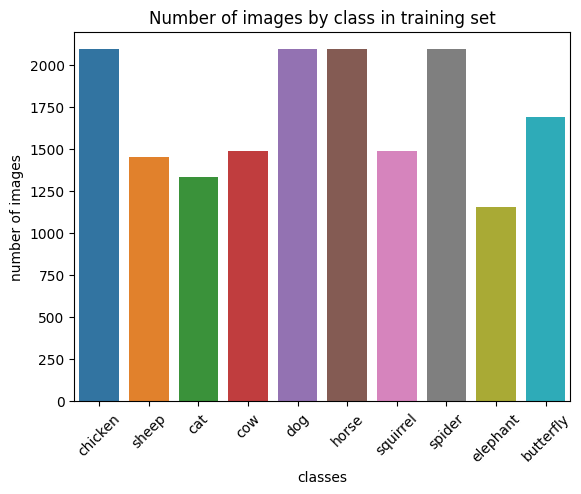

In [7]:
path = 'data/animals/training'

objects = os.listdir(path)

images = []

for item in objects:
  number_of_images = len(os.listdir(path + '/' + item))
  images.append(number_of_images)

sns.barplot(x=objects, y=images)
plt.xlabel('classes')
plt.ylabel('number of images')
plt.title('Number of images by class in training set')
plt.xticks(rotation=45)
plt.show()

тут ми бачимо вже новий розподіл, на якому ми і будемо тренувати модель

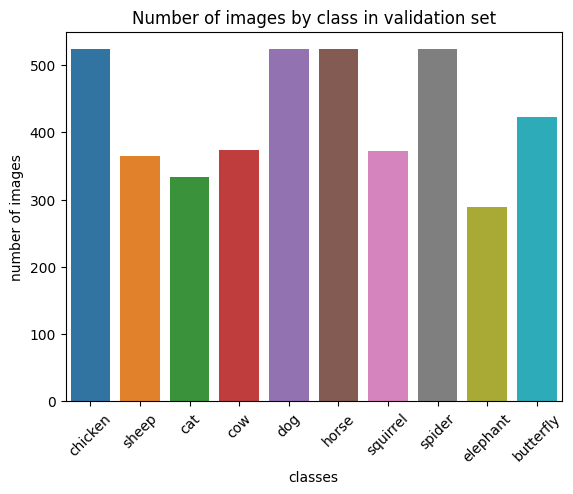

In [8]:
path = 'data/animals/validation'

objects = os.listdir(path)
images = []

for item in objects:
  number_of_images = len(os.listdir(path + '/' + item))
  images.append(number_of_images)

sns.barplot(x=objects, y=images)
plt.xlabel('classes')
plt.ylabel('number of images')
plt.title('Number of images by class in validation set')
plt.xticks(rotation=45)
plt.show()

і такий же розподіл для тестування

In [9]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

у трансформації ми змінюємо картинки під один розмір (256, 256), бо у вихідного датасету зображення різного розміру. Далі ми перетворюємо зображення у тензор

In [10]:
path = 'data/animals'

методом ImageFolder ми перетворюємо наші муторно розділені папки в датасети для тренування та тестування

In [80]:
dataset = ImageFolder(path + '/training', transform=transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 17001


In [81]:
test = ImageFolder(path + '/validation', transform=transform)
print('Size of test dataset :', len(test))

Size of test dataset : 4245


у гугл колабі я користуюсь кудою, тому відповідно зазначаємо це в device

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [83]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 256, 256])


нижче на прикладах можна побачити, як виглядатимуть наші перетворені зображення

Label:  butterfly (0)


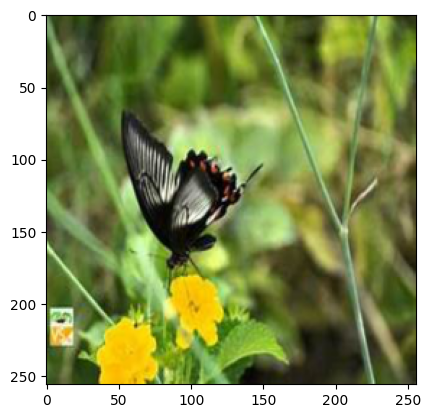

In [84]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[9])

Label:  cat (1)


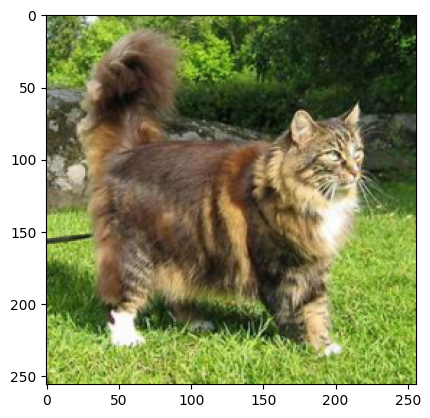

In [85]:
show_example(*dataset[2020])

Label:  chicken (2)


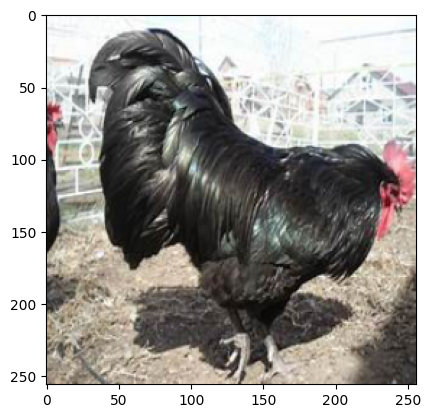

In [86]:
show_example(*dataset[4020])

розділяємо дані для тренування та валідації

In [87]:
torch.manual_seed(43)
val_size = 1500
train_size = len(dataset) - val_size

In [88]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(15501, 1500)

обираємо batch size побільше і завантажуємо дані через data loader, додатково дивимося на приклад

In [89]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


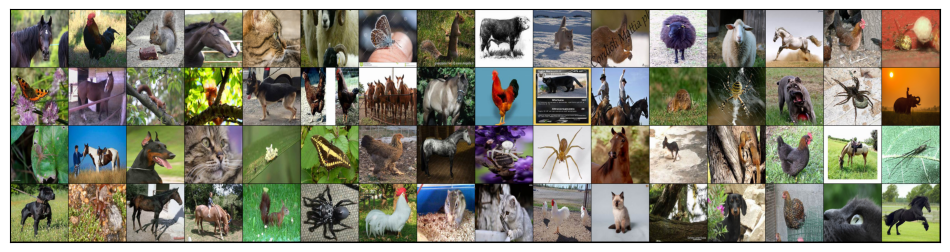

In [90]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

у моделі я використовую 6 згорток та 3 повністю зʼєднаних шари. після кожної згортки застосовуємо max pooling і relu

In [92]:
class LeNet(nn.Module):
    def __init__(self, gray=False):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, kernel_size=3)
        self.conv2 = nn.Conv2d(100,150, kernel_size=3)
        self.conv3 = nn.Conv2d(150, 200, kernel_size=3)
        self.conv4 = nn.Conv2d(200, 200, kernel_size=3)
        self.conv5 = nn.Conv2d(200, 250, kernel_size=3)
        self.conv6 = nn.Conv2d(250, 250, kernel_size=3)

        self.fc1 = nn.Linear(1000,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv6(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

далі йдуть основні методи для тестування та перевірки нейронної мережі

In [93]:
def loss(model, loss_func, X, y, optimizer=None):
    loss = loss_func(model(X), y)
    if optimizer is not None:
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss.item(), len(X)

In [94]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss.item(), torch.sum(correct).item(), len(X)

In [101]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.Inf

    for epoch in tqdm(range(epochs)):

        model.train()

        losses = []
        for X, y  in train_loader:
          X, y = X.to(device), y.to(device)
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              X, y = X.to(device), y.to(device)
              losses.append(validate(model, loss_func, X, y))

            losses, corrects, nums = zip(*losses)
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accruacy: {valid_accuracy:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy))

            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses

    return graphic_losses


In [102]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          X, y = X.to(device), y.to(device)
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums = zip(*validated_batches)
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100

    print(f"Test loss: {test_loss:.5f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [103]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(n_epochs) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(n_epochs) if x % 2 == 1])
    plt.show()

In [104]:
def train(model, criterion, optimizer, n_epochs, transforms, saving_model_path=None, custom_train_path=None):
    print('\nFitting nn model')
    start_time = time.time()

    losses_arr = fit(n_epochs, model, criterion, optimizer, train_loader, val_loader)
    print(f'Fit time: {time.time() - start_time} s')

    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    evaluate(model, criterion, test_loader)

    # if saving_model_path is not None:
    #     print('Saving model')
    #     torch.save(model.state_dict(), model_path(saving_model_path))

    training_plots(losses_arr)

ініціалізуємо модель та тренуємо її

In [109]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 12


Fitting nn model


  8%|▊         | 1/12 [02:00<22:00, 120.05s/it]


epoch:   1, loss: 2.26939, valid loss: 2.17359, valid accruacy: 20.333%
Validation loss decreased (inf --> 2.173587). Saving model...


 17%|█▋        | 2/12 [04:03<20:18, 121.80s/it]


epoch:   2, loss: 1.99822, valid loss: 1.84290, valid accruacy: 33.667%
Validation loss decreased (2.173587 --> 1.842904). Saving model...


 25%|██▌       | 3/12 [06:07<18:28, 123.14s/it]


epoch:   3, loss: 1.72137, valid loss: 1.61732, valid accruacy: 41.400%
Validation loss decreased (1.842904 --> 1.617318). Saving model...


 33%|███▎      | 4/12 [08:16<16:41, 125.17s/it]


epoch:   4, loss: 1.50321, valid loss: 1.42907, valid accruacy: 50.267%
Validation loss decreased (1.617318 --> 1.429066). Saving model...


 42%|████▏     | 5/12 [10:17<14:26, 123.83s/it]


epoch:   5, loss: 1.31692, valid loss: 1.28843, valid accruacy: 55.400%
Validation loss decreased (1.429066 --> 1.288429). Saving model...


 50%|█████     | 6/12 [12:29<12:40, 126.67s/it]


epoch:   6, loss: 1.16943, valid loss: 1.22950, valid accruacy: 58.533%
Validation loss decreased (1.288429 --> 1.229499). Saving model...


 58%|█████▊    | 7/12 [14:32<10:27, 125.43s/it]


epoch:   7, loss: 1.07574, valid loss: 1.15671, valid accruacy: 60.933%
Validation loss decreased (1.229499 --> 1.156712). Saving model...


 67%|██████▋   | 8/12 [16:43<08:28, 127.11s/it]


epoch:   8, loss: 0.95649, valid loss: 1.10347, valid accruacy: 63.067%
Validation loss decreased (1.156712 --> 1.103466). Saving model...


 75%|███████▌  | 9/12 [18:52<06:23, 127.79s/it]


epoch:   9, loss: 0.85277, valid loss: 1.07036, valid accruacy: 63.800%
Validation loss decreased (1.103466 --> 1.070364). Saving model...


 83%|████████▎ | 10/12 [20:56<04:13, 126.67s/it]


epoch:  10, loss: 0.76142, valid loss: 1.14403, valid accruacy: 63.600%


 92%|█████████▏| 11/12 [23:03<02:06, 126.72s/it]


epoch:  11, loss: 0.67556, valid loss: 1.18749, valid accruacy: 63.600%


100%|██████████| 12/12 [25:07<00:00, 125.65s/it]


epoch:  12, loss: 0.60910, valid loss: 1.04132, valid accruacy: 67.267%
Validation loss decreased (1.070364 --> 1.041316). Saving model...
Fit time: 1507.863004207611 s


Test loss: 1.04093	Test accruacy: 66.007%


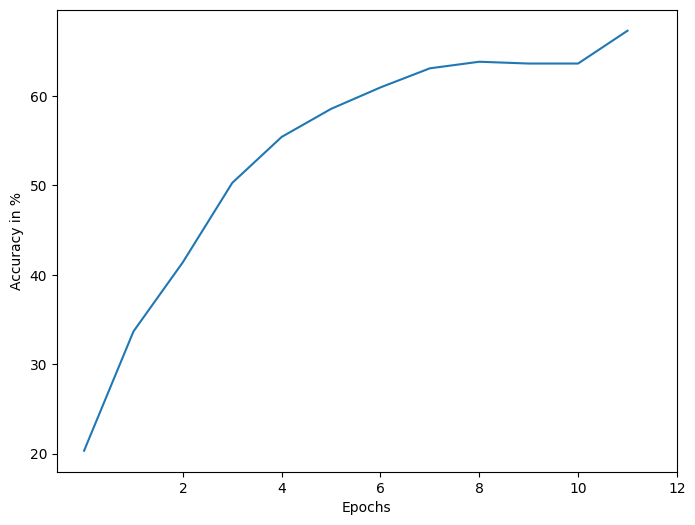

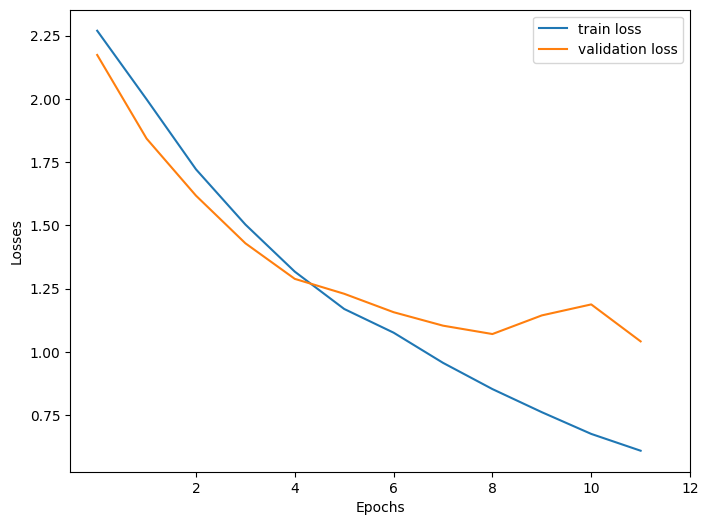

In [110]:
train(model, criterion, optimizer, n_epochs, transforms.ToTensor(), 'base_model')

за 12 епох ми досягли точності у 67 відсотків на тренувальній та 66 на тестувальній вибірках. далі ми зберігаємо модель

In [111]:
torch.save(model, 'model.pt')